In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
acident_index_train=[31,35,36,45,50,52,55,56,60,67,68,69,76,78,84,90,91,92,94,95,96,98,100,102,103,106,109,116,117,120,121,123,128,129,130,131,132,133,136,138,145,147,148,151,152,153,154,155,159,161]
acident_index_test=[162,166,170,171,173,174,176,177,180,181,184,187,188,189,190,193,197,198,199,201,202,204,205,212,213,216,218,219,220,221,226,231,233,236,240,241,242,243,244,252]
trafic_data=pd.read_parquet("traffic_data.parquet")
incident=pd.read_csv("incidents.csv")
trafic_data["timestamp"] = pd.to_datetime(trafic_data["timestamp"])
incident["timestamp"] = pd.to_datetime(incident["timestamp"])
pd.set_option('display.max_columns', None)
incident

2023-09-12 16:03:49.358408: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 16:03:49.480142: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 16:03:49.481571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 16:03:50.600833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Unnamed: 0,incident_id,cc_code,timestamp,description,latitude,longitude,district,freeway_nmbr,freeway_direction,state_postmile,abs_postmile,duration,up_id,up_lanes,up_distance,up_latitude,up_longitude,down_id,down_lanes,down_distance,down_latitude,down_longitude,active_onramp,active_offramp
0,0,16175990,SAHB,2016-01-01 16:30:00,1179-Trfc Collision-1141 Enrt,38.280275,-121.456931,3.0,5,N,NaN,497.1,70.0,317393,2,-1.607,38.257363,-121.448669,319227,2,0.101,38.281219,-121.457043,False,False
1,1,16177033,SAHB,2016-01-02 13:25:00,1183-Trfc Collision-Unkn Inj,39.314110,-120.447967,3.0,80,W,NaN,170.6,60.0,317798,2,3.203,39.325458,-120.392564,319430,2,-5.605,39.310097,-120.544000,True,True
2,2,16177599,SAHB,2016-01-02 19:00:00,1182-Trfc Collision-No Inj,38.603209,-121.435469,3.0,51,S,NaN,4.0,40.0,318540,4,0.196,38.605475,-121.433198,314157,4,-0.271,38.600753,-121.438775,True,True
3,3,16182414,SAHB,2016-01-08 07:45:00,1179-Trfc Collision-1141 Enrt,38.343525,-121.335578,3.0,99,N,NaN,281.8,45.0,317652,2,-0.730,38.333162,-121.330741,317660,2,0.730,38.352842,-121.340605,False,False
4,4,16183558,SAHB,2016-01-08 17:10:00,1182-Trfc Collision-No Inj,38.560374,-121.481408,3.0,50,E,NaN,5.2,80.0,312139,5,-0.477,38.562532,-121.489560,318282,4,0.122,38.559773,-121.479137,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,16907027,SAHB,2016-12-26 13:05:00,1179-Trfc Collision-1141 Enrt,38.758050,-121.261450,3.0,80,E,3.087,104.6,65.0,318801,4,-0.126,38.756912,-121.262242,318844,4,0.070,38.759443,-121.260582,False,False
448,448,16908065,SAHB,2016-12-27 05:50:00,1179-Trfc Collision-1141 Enrt,38.249222,-121.290476,3.0,99,S,0.355,274.8,50.0,319100,2,0.350,38.253209,-121.292972,317640,2,-0.134,38.246918,-121.288935,False,False
449,449,16908856,SAHB,2016-12-27 14:15:00,1179-Trfc Collision-1141 Enrt,38.651912,-121.370190,3.0,80,W,R11.462,95.1,50.0,313368,6,0.200,38.653680,-121.368403,314165,2,-0.895,38.645422,-121.384400,False,False
450,450,16911088,SAHB,2016-12-28 18:05:00,1183-Trfc Collision-Unkn Inj,38.596708,-121.549171,3.0,80,W,R11.6,83.8,75.0,319142,3,0.477,38.603117,-121.544779,317885,3,-0.613,38.589094,-121.554290,False,False


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler
# Convert timestamp to integer for model input
def lstm_result(x):
    train=pd.DataFrame()
    result = trafic_data[(trafic_data['station_id'] == incident.at[x,'up_id'])&(trafic_data['timestamp'] <= incident.at[x,'timestamp'] + timedelta(hours=6))&(trafic_data['timestamp'] >= incident.at[x,'timestamp'] + timedelta(hours=-10))]
    result['current']=0
    result.loc[(result['timestamp'] >= incident.at[x,'timestamp'])&(result['timestamp'] <= incident.at[x,'timestamp']+ timedelta(minutes=incident.at[x,'duration'])), 'current'] = 1
    train = pd.concat([train, result], axis=0)
    train["timestamp"] = pd.to_datetime(train["timestamp"])
    scaler = StandardScaler()
    scaler.fit(train[["speed"]])
    train[["speed"]] = scaler.fit_transform(train[["speed"]])

    df=train[(train['timestamp'] >=  train['timestamp'].iloc[0]) & (train['timestamp'] <= train['timestamp'].iloc[0] + timedelta(hours=4))]
    df=df[['speed','timestamp']]
    df['timestamp'] = df['timestamp'].astype(np.int64)
    train['timestamp'] = train['timestamp'].astype(np.int64)
    # Define input sequence length
    sequence_length = 30
    # Create sequences for training
    sequences = []
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i + sequence_length]
        sequences.append(sequence)
    # Convert sequences to NumPy arrays
    X = np.array([sequence['timestamp'].values for sequence in sequences])
    y = np.array([sequence['speed'].values[-1] for sequence in sequences])
    # Reshape input to match LSTM input shape
    X = X.reshape(X.shape[0], X.shape[1], 1)
    # Build LSTM model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=(sequence_length, 1)),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X, y, epochs=10, batch_size=1,verbose=0)
    result = pd.DataFrame(columns=['timestamp', 'speed', 'current_predicted'])
    i=0
    for index, row in train.iterrows():
        if row['timestamp'] in df['timestamp'].values :
            continue
        else: 
            a=pd.Series({'timestamp': row['timestamp'],
                                 'speed': row['speed']})
            df=pd.concat([df, a.to_frame().T], ignore_index=True)
            # Re-create sequences for training with the updated DataFrame
            sequences = []
            for i in range(len(df) - sequence_length):
                sequence = df.iloc[i:i + sequence_length]
                sequences.append(sequence)
            new_sequence = sequences[-1]
            new_X = np.array([new_sequence['timestamp'].values])
            new_X = new_X.reshape(new_X.shape[0], new_X.shape[1], 1)
            predicted_speed = model.predict(new_X)
            result = result.append({'timestamp': row['timestamp'], 'speed': row['speed'], 'current_predicted': predicted_speed[0][0]}, ignore_index=True)
            X = np.array([sequence['timestamp'].values for sequence in sequences])
            y = np.array([sequence['speed'].values[-1] for sequence in sequences])
            X = X.reshape(X.shape[0], X.shape[1], 1)
            # Re-train the model with the updated data
            i+=1
            if ((i%4)==0):
                model.fit(X, y, epochs=2, batch_size=1,verbose=0)
    result[["speed"]] = scaler.inverse_transform(result[["speed"]])
    result[["current_predicted"]] = scaler.inverse_transform(result[["current_predicted"]])
    result['timestamp'] = pd.to_datetime(result['timestamp'], unit='ns')
    result['current_predicted'] = ((result['speed'] - result['current_predicted'])/ result['speed'])
    result['current_predicted'] =result['current_predicted'].abs()
    result['current_predicted'] = result['current_predicted'].apply(lambda x: 0 if x < 0.25 else 1)      
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ns')
    result1 = pd.merge(result[['timestamp','current_predicted']], train, on=['timestamp'], how='inner')
    return(result1)


result=lstm_result(188)

1/1 [==============================] - 0s 18ms/step


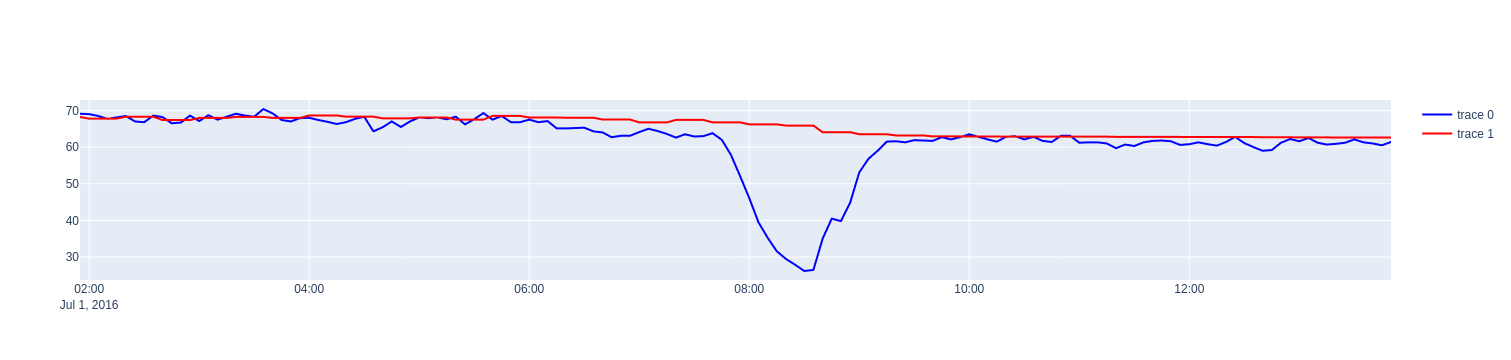

In [ ]:
fig = go.Figure()
fig.add_scattergl(x=result["timestamp"], y=result["speed"], line={'color': 'blue'})
fig.add_scattergl(x = result["timestamp"], y = result["speed"].where(result["current_predicted"] == 1), line ={'color' : 'red'})
fig.show()

In [4]:
import time
st = time.time()
def score(list):
    No_of_congestions_detected1=0
    No_of_true_congestions=len(list)
    No_of_false_alarms_signals=0
    No_of_non_congestion_instances=0
    No_of_congestions_detected=0
    sum_of_time=0
    for x in list:
        result=lstm_result(x)
        if result.query('1== current_predicted and 1 ==current').shape[0]>1:
            No_of_congestions_detected1+=1
        No_of_non_congestion_instances+=result.query('0 ==current').shape[0]
        if result.query('1== current_predicted and 0 ==current').shape[0]>1:
            No_of_false_alarms_signals+=result.query('1== current_predicted and 0 ==current').shape[0]
        if result.query('1== current_predicted and 1 ==current').shape[0]>1:
            sum_of_time+=(result[(result.current_predicted == 1) &(result.current == 1)].iloc[0]["timestamp"]-incident.at[x,'timestamp']).total_seconds() / 60
            No_of_congestions_detected+=1
    x=(No_of_congestions_detected1/No_of_true_congestions)
    y=(No_of_false_alarms_signals/No_of_non_congestion_instances)
    z=(sum_of_time/No_of_congestions_detected)
    return [x, y , z]
score=score(acident_index_test)
et = time.time()
prediction_time = et - st

1/1 [==============================] - 0s 21ms/step


## full time for training and prediction

In [5]:
prediction_time

3457.7127208709717

## dr score

In [6]:
print(score[0])

0.95


## far score

In [7]:
print(score[1])

0.04776288465168964


## MTTD score

In [8]:
print(score[2])

2.8947368421052633
